In [1]:
#Library of functions so far

In [1]:
import json
import zipfile
import pandas as pd
import numpy as np
import csv as csv
import matplotlib.pyplot as plt



#return a text parser for the large file, with chunk size "sz"
def load_train(sz=100):
    zf = zipfile.ZipFile("../data/train.csv.zip")
    return pd.read_csv(zf.open('train.csv'), chunksize=sz, iterator=True, converters={'POLYLINE': lambda x: json.loads(x)})

def load_test(sz=100):
    zf = zipfile.ZipFile("../data/test.csv.zip")
    return pd.read_csv(zf.open('test.csv'), chunksize=sz, iterator=True, converters={'POLYLINE': lambda x: json.loads(x)})


#remove rows with empty POLYLINE field
def rem_empty_polyline(X):
    empty_rows=[]
    for j in range(len(X['POLYLINE'])):      
        entry=X['POLYLINE'].values[j]
        if(entry==[]):
                  empty_rows.append(j)
    return X.drop(X.index[empty_rows])
    

#remove rows with incomplete GPS data (only ten cases)
def rem_missing(X):
    empty_rows=[]
    for j in range(len(X['MISSING_DATA'])):      
        entry=X['MISSING_DATA'].values[j]
        if(entry=="True"):
            empty_rows.append(j)
    return X.drop(X.index[empty_rows])    
    
    

#add the last latitude and longitude from the POLYLINE field to main dataframe X and return it 
def lat_long_last(X):

    latitudes=[]
    longitudes=[]
    
    for j in range(len(X['POLYLINE'])):      
        entry=X['POLYLINE'].values[j]
        if(len(entry)==0):
            latitudes.append(-999)
            longitudes.append(-999)
        else:
            last=entry[-1]           
            latitudes.append(last[0])
            longitudes.append(last[1])
            
    X['LAST_LAT']=longitudes 
    X['LAST_LON']=latitudes
    
    return X



#add the first latitude and longitude from the POLYLINE field to main dataframe X and return it 
def lat_long_first(X):
    
    latitudes=[]
    longitudes=[]
    
    for j in range(len(X['POLYLINE'])):      
        entry=X['POLYLINE'].values[j]
        if(len(entry)==0):
            latitudes.append(-999)
            longitudes.append(-999)
        else:
            last=entry[0]           
            latitudes.append(last[0])
            longitudes.append(last[1])
            
    X['FIRST_LAT']=longitudes 
    X['FIRST_LON']=latitudes
    
    return X



# add the first latitude and longitude from the POLYLINE field to main dataframe X and return it 
def lat_long_2ndToLast(X):
    
    latitudes=[]
    longitudes=[]
    
    for j in range(len(X['POLYLINE'])):      
        entry=X['POLYLINE'].values[j]
        if(len(entry)==0):
            latitudes.append(-999)
            longitudes.append(-999)
        elif(len(entry)==1):
            last=entry[-1]           
            latitudes.append(last[0])
            longitudes.append(last[1])            
        else:
            last=entry[-2]           
            latitudes.append(last[0])
            longitudes.append(last[1])
            
    X['S2L_LAT']=longitudes 
    X['S2L_LON']=latitudes
    
    return X



#
# Evaluation metric -- appears to be off by factor of 2
#

d_2_rad=np.pi/180.0

#compute haversine distance between two coordinates (phi_1,lambda_1) and (phi_2,lambda_2)
def haversine(phi_1,lambda_1,phi_2,lambda_2):
    r=6371  #kilometers
    #r=3959 #miles
    a= np.sin(d_2_rad*(phi_2-phi_1))**2+np.cos(d_2_rad*phi_1)*np.cos(d_2_rad*phi_2)*np.sin(d_2_rad*(lambda_2-lambda_1))**2
    return 2*r*np.arctan(np.sqrt(a/(1-a)))



#compute the mean haversine distance between -- not safe, make sure all array dimensions are the same
def mean_haversine(phi_1s,lambda_1s,phi_2s,lambda_2s):

    total=0
    m=len(phi_1s)
    for j in range(m):
        #print haversine(phi_1s[j],lambda_1s[j],phi_2s[j],lambda_2s[j])
        total+=haversine(phi_1s[j],lambda_1s[j],phi_2s[j],lambda_2s[j])

    return total/m
        


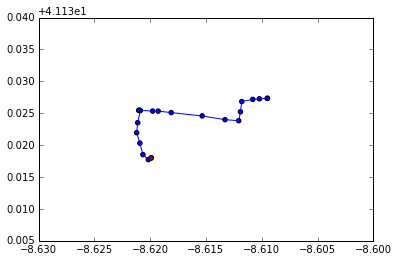

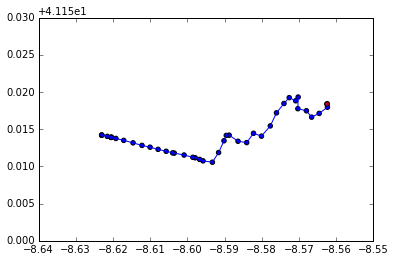

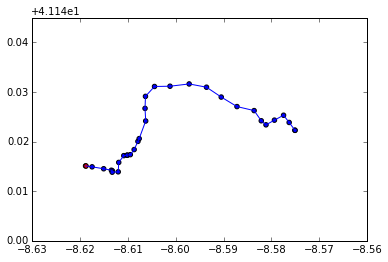

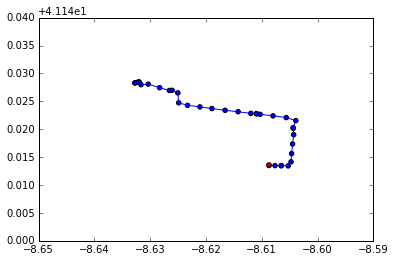

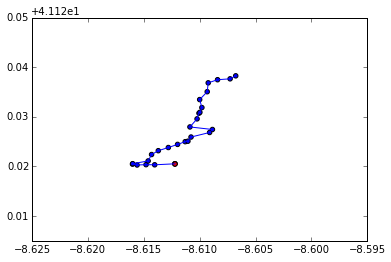

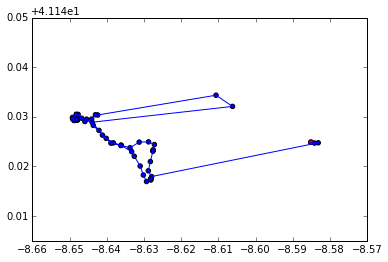

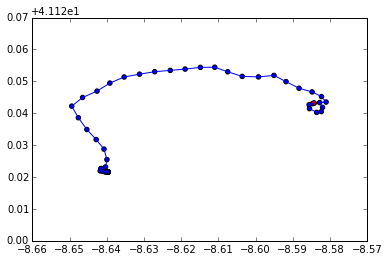

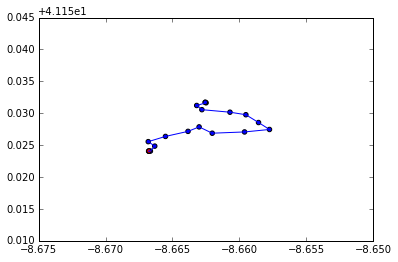

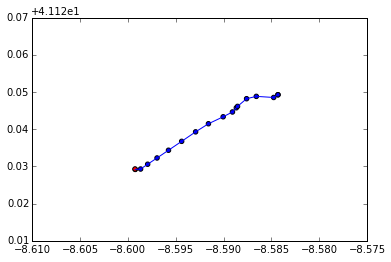

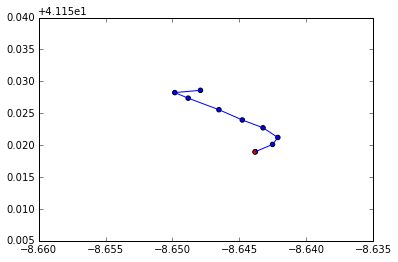

In [59]:
#
# Plot a few routes
#
%matplotlib inline 
train_parser=load_train(10)

k=0
plot_chunk=1

for chunk in train_parser:
    chunk=rem_missing(chunk)
    if (k==plot_chunk):
        for j in range(len(chunk.POLYLINE)):
            entry=chunk['POLYLINE'].values[j]
            entry=np.array(entry)
            plt.scatter(entry[:,0],entry[:,1],  c=(["red"]+["blue"]*(len(entry[:,0])-1)))
            plt.plot(entry[:,0],entry[:,1])
            plt.scatter(entry[0,0],entry[0,1], c=["red"])
            plt.show()
        break
    k+=1

#Observations

*Many paths double back on themselves or "spiral/zig-zag" towards destination -- in a very loose sense

*Some paths appear to be missing data even though they are not marked as missing data.




In [60]:
# Plot trips of types A, B, and C
## Type A are dispatched from central
## Type B are from a taxi stand
## Type C are from street pick ups

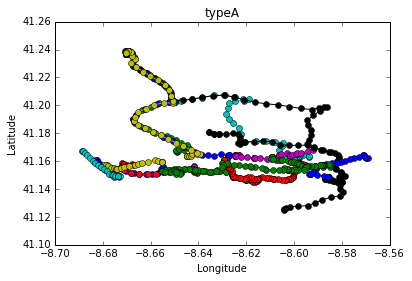

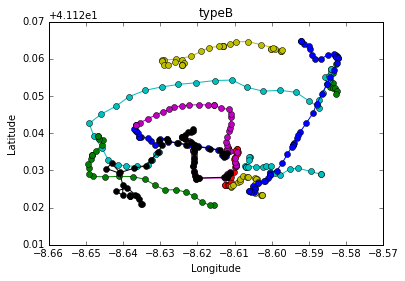

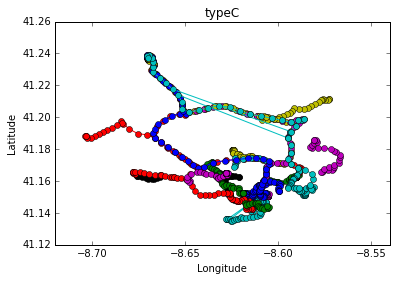

In [4]:
%matplotlib inline 

train_parser=load_train(50)

k=0
plot_chunk=5

for chunk in train_parser:
    chunk=rem_missing(chunk)
    if (k==plot_chunk):
        for tp in ['A','B','C']:
            for j in range(len(chunk.POLYLINE)):
                if(chunk.CALL_TYPE[j]==tp):
                    entry=chunk['POLYLINE'].values[j]
                    entry=np.array(entry)
                    plt.title("type"+str(tp))
                    #plt.scatter(entry[:,0],entry[:,1],  c=(["red"]+["blue"]*(len(entry[:,0])-1)))
                    plt.plot(entry[:,0],entry[:,1], '-o')
                    plt.xlabel("Longitude")
                    plt.ylabel("Latitude")
                    plt.scatter(entry[0,0],entry[0,1], c=["red"])
                    plt.savefig(tp+"_trajectories.png")
            plt.show()
            plt.close()
        break
    k+=1

True

In [66]:
plt.close()

In [65]:
#Look at day/holiday information
# So few days are holidays it seems pointless to consider them separately at this point

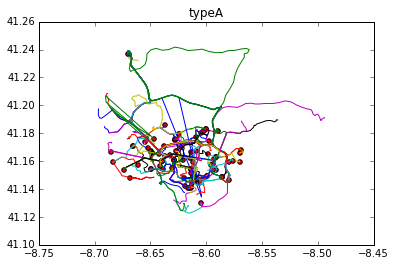

In [4]:
%matplotlib inline 

train_parser=load_train(100)

k=0
plot_chunk=4

for chunk in train_parser:
    chunk=rem_missing(chunk)
    if (k==plot_chunk):
        for day in ['A','B','C']:
            for j in range(len(chunk.POLYLINE)):
                if(chunk.DAY_TYPE[j]==day):
                    entry=chunk['POLYLINE'].values[j]
                    entry=np.array(entry)
                    plt.title("type"+str(day))
                    #plt.scatter(entry[:,0],entry[:,1],  c=(["red"]+["blue"]*(len(entry[:,0])-1)))
                    plt.plot(entry[:,0],entry[:,1], '-', )
                    plt.scatter(entry[0,0],entry[0,1], c=["red"])                   
            plt.show()
            plt.close()
        break
    k+=1

In [77]:
chunk.DAY_TYPE[1]

'A'

In [3]:
plt.plot?

#Look at test paths to get an idea of truncation spot

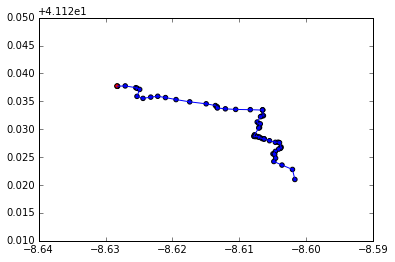

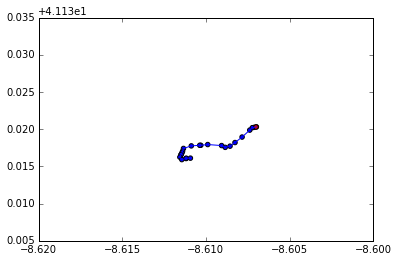

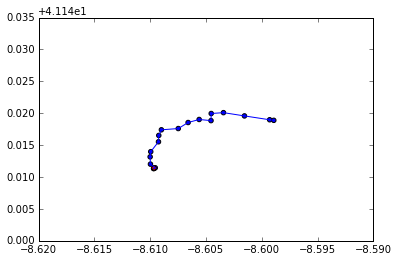

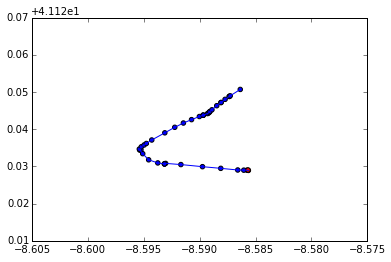

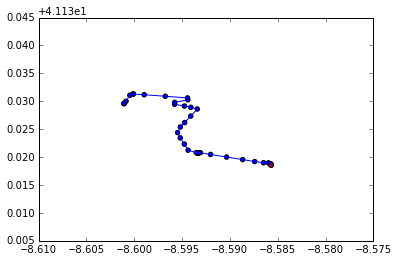

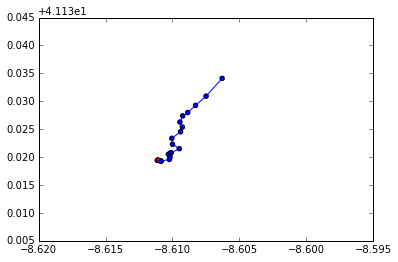

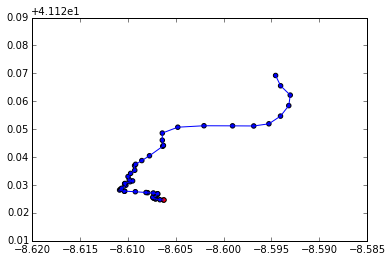

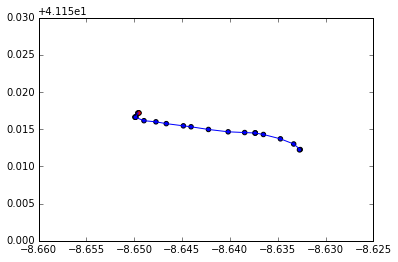

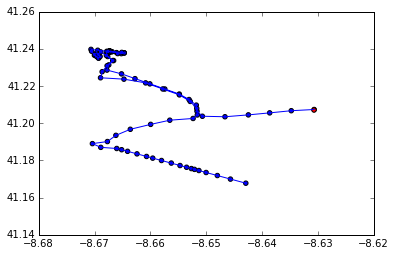

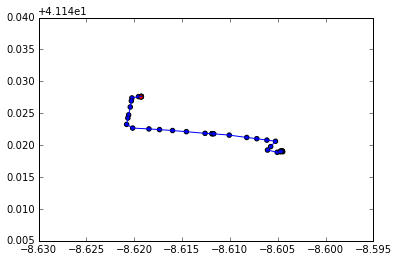

In [3]:
#
# Plot a few routes
#
%matplotlib inline 
parser=load_test(10)

k=0
plot_chunk=5

for chunk in parser:
    chunk=rem_missing(chunk)
    if (k==plot_chunk):
        for j in range(len(chunk.POLYLINE)):
            entry=chunk['POLYLINE'].values[j]
            entry=np.array(entry)
            plt.scatter(entry[:,0],entry[:,1],  c=(["red"]+["blue"]*(len(entry[:,0])-1)))
            plt.plot(entry[:,0],entry[:,1])
            plt.scatter(entry[0,0],entry[0,1], c=["red"])
            plt.show()
        break
    k+=1